# Fundamentals of Medical Image Processing for Deep Learning

- toc :True

In [1]:
import numpy as np
import pandas as pd 
import scipy.ndimage 
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.cluster import KMeans
import shutil
import cv2
import pydicom
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import seaborn as sns
from IPython.display import HTML
import gdcm
import os


In [2]:
def set_options():
    pd.set_option('display.max_columns', 100)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.max_rows', 1000)

In [3]:
set_options()

## Loading the Data

In [4]:
TRAIN_PATH = 'osic-pulmonary-fibrosis-progression/train.csv'
TRAIN_IMG_PATH = 'osic-pulmonary-fibrosis-progression/train'
TEST_PATH = 'osic-pulmonary-fibrosis-progression/test.csv'
TEST_IMG_PATH = 'osic-pulmonary-fibrosis-progression/test'
SUBMISSION_PATH = 'osic-pulmonary-fibrosis-progression/sample_submission.csv'

In [5]:
''' Load CSV data'''

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

In [6]:
# finding and removing some duplicates

train[train.duplicated(['Patient', 'Weeks'], keep = False)]

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
166,ID00048637202185016727717,9,1375,60.059404,70,Female,Never smoked
167,ID00048637202185016727717,9,1477,64.514720,70,Female,Never smoked
226,ID00068637202190879923934,11,2794,82.633385,73,Male,Ex-smoker
227,ID00068637202190879923934,11,2827,83.609369,73,Male,Ex-smoker
306,ID00089637202204675567570,7,2478,57.967624,63,Male,Never smoked
307,ID00089637202204675567570,7,2539,59.394592,63,Male,Never smoked
465,ID00125637202218590429387,8,2349,53.757781,65,Male,Never smoked
466,ID00125637202218590429387,8,2584,59.135848,65,Male,Never smoked
750,ID00199637202248141386743,5,2672,64.728682,62,Male,Ex-smoker
751,ID00199637202248141386743,5,2683,64.995155,62,Male,Ex-smoker


In [7]:
# Remove duplicates

train = train.drop_duplicates()

In [8]:
train.head(10)

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
5,ID00007637202177411956430,17,2101,52.868646,79,Male,Ex-smoker
6,ID00007637202177411956430,29,2000,50.327126,79,Male,Ex-smoker
7,ID00007637202177411956430,41,2064,51.937594,79,Male,Ex-smoker
8,ID00007637202177411956430,57,2057,51.761449,79,Male,Ex-smoker
9,ID00009637202177434476278,8,3660,85.282878,69,Male,Ex-smoker


In [9]:
## Vido about dicom

HTML('<iframe width="600" height="400" src="https://www.youtube.com/embed/KZld-5W99cI" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

/home/siddy/anaconda3/envs/torch/lib/python3.8/site-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [10]:
# scan - whole 3d image, slice - every 2d img of scan

# In this dataset the ImagePosition is not available so we'll sort the slices on Instance Number

def load_slices(path):
    filenames = os.listdir(path)
    slices = [pydicom.dcmread(f'{path}/{file}') for file in filenames]
    slices.sort(key = lambda x: int(x.InstanceNumber), reverse=True)
    return slices

In [11]:
scans = load_slices(f'{TRAIN_IMG_PATH}/ID00007637202177411956430')
print(len(scans))
# here is the first slice of dicom 
scans[0]

30


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.95516132172461492040664114239048418896
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.1
(0002, 0013) Implementation Version Name         SH: 'OSIRIX_361'
(0002, 0016) Source Application Entity Title     AE: 'ANONYMOUS'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0018) SOP Instance UID                    UI: 2.25.95516132172461492040664114239048418896
(0008, 0060) Modality                            CS: 'CT'
(0008, 0070) 

Some Meta Data Which is useful for processing

1. Slice Thickness: it is distance b/w two slices, further useful for getting the volume of the image
2. Image Orientation (patient) and Slice Location comes in use when the Slice Thickness is not given in the dataset 
so, slice thickness = difference b/w slice location of any two slices
3. Pixel Spacing is vimp metadata, it gives pixel size x and y coordinates 
4. window center and the window window width are vimp as they give region of interest

## Conversion in Hounsfeild Units

It basically gives the density of the tissue, so to convert the slices in the HU domain we take every slice and do,
slice * Rescalse Slope + Rescale Intercept
which is just a linear transformation

In [12]:
# convert pixel value to real world value

def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)
    
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image <= -1000] = 0
    
    # convert to HU
    
    for slice_number in range(len(slices)):
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)


## Windowing

windowing is the seletion of range of range of greyscale in the image that we need, basically it gives the region of interest using parameters like window width and window level(center)

window width -  greyscale which can be displayed on the image, we do not want the black color bcoz that is the air, we do not want that density to show, so we adjust these greyscale range so that we can just get only the lung portion of that.

window center or level - center of that particular range of that window width 

in our case
WW of 100 HU could mean the grayscale only ranges from 0HU to +100 HU, with a WL of +50 HU. For Lungs window width is 1500 and window level is -600, so grayscale ranges from 150HU to -1350HU. More about windowing can be read [here](https://radiopaedia.org/articles/windowing-ct?lang=us). How to get window width and level is explained briefly in [this](https://www.researchgate.net/publication/272179277_Determining_effective_window_width_and_center_using_different_windowing_techniques_for_radio_therapy_images) article.

In [13]:
def apply_window(hu_image, center, width):
    hu_image = hu_image.copy()
    min_value = center - width // 2
    max_value = center + width // 2
    hu_image[hu_image < min_value] = min_value
    hu_image[hu_image > max_value] = max_value
    return hu_image

## Histogram Analysis
Lets plot histogram for image pixels after converting to HU and raw pixel values. After converting to HU we can see there is lot of air(-1000) in the scan. Some fat and muscle is also seen.

In [14]:
train.loc[0]['Patient']

'ID00007637202177411956430'

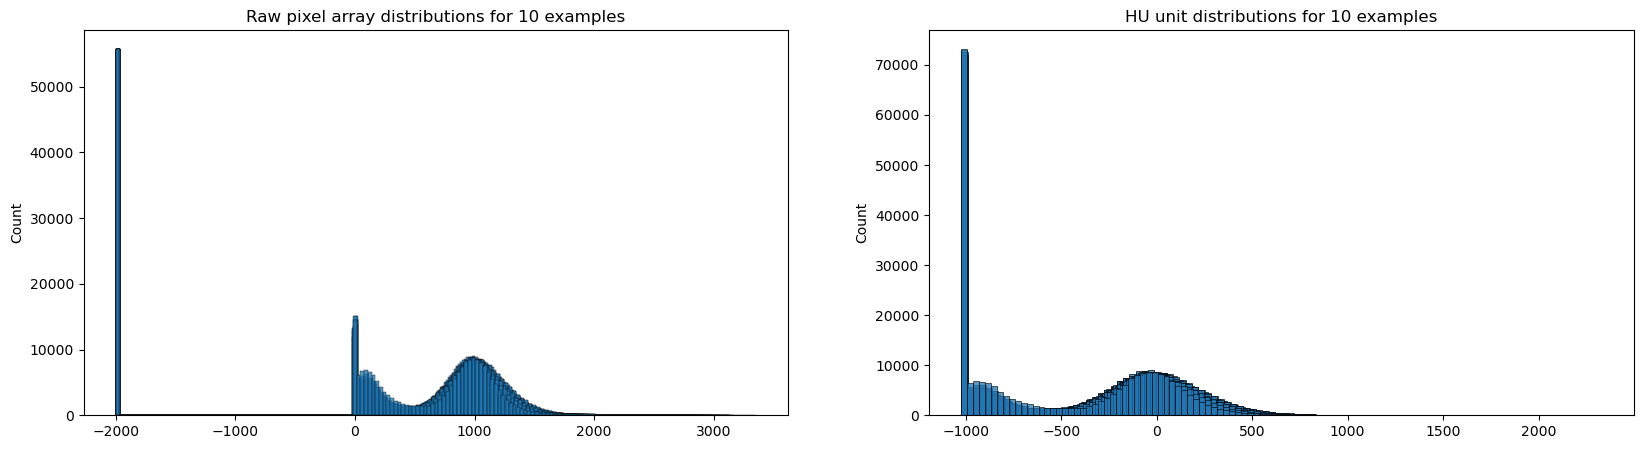

In [15]:
fig, ax = plt.subplots(1, 2, figsize= (20, 5))
example = train.loc[0]['Patient']
scans = load_slices(f'{TRAIN_IMG_PATH}/{example}')
rescaled_images = get_pixels_hu(scans)
images = [scan.pixel_array for scan in scans]
for i in range(10):
    sns.histplot(images[i].flatten(), ax=ax[0])
    sns.histplot(rescaled_images[i].flatten(), ax=ax[1])
    
ax[0].set_title("Raw pixel array distributions for 10 examples")
ax[1].set_title("HU unit distributions for 10 examples")

plt.show()

## Storing Metadata in Dataframe

In [16]:
# we are storing metadata not PixelData which is the IMAGE
def get_dicom_raw(dicom):
    return ({attr:getattr(dicom, attr) for attr in dir(dicom) if attr[0].isupper() and attr not in ['PixelData']})

In [17]:
%%time
# Get dicom metadata
# Image features like lung volume are implementation from a detailed discussion "Domain expert's insight" by Dr. Konya.
# https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/discussion/165727

def get_dicom_metadata(df):
    patients = df.Patient.unique()
    dicom_metadata = []
    for patient in patients:
        path = f'{TRAIN_IMG_PATH}/{patient}'
        img_list = os.listdir(path)
        for img in img_list:
            image = pydicom.dcmread(f'{path}/{img}')
            record = get_dicom_raw(image)
            raw = image.pixel_array
            pixelspacing_r, pixelspacing_c = image.PixelSpacing[0], image.PixelSpacing[1]
            row_distance = pixelspacing_r * image.Rows
            col_distance = pixelspacing_c * image.Columns
            record.update({'raw_min':raw.min(),
                        'raw_max':raw.max(),
                        'raw_mean':raw.mean(),
                        'raw_std':raw.std(),
                        'raw_diff':raw.max()-raw.min(),
                        'pixel_spacing_area':pixelspacing_r * pixelspacing_c,
                        'img_area':image.Rows * image.Columns,
                        'pixel_row_distance':row_distance,
                        'pixel_col_distance':col_distance,
                        'slice_area_cm2':(0.1 * row_distance) * (0.1 * col_distance),
                        'slice_vol_cm3':(0.1 * image.SliceThickness) * (0.1 * row_distance) * (0.1 * col_distance),
                        'patient_img_path':f'{path}/{img}'})

            dicom_metadata.append(record)
            
    metadata_df = pd.DataFrame(dicom_metadata)
    metadata_df.to_pickle('metadata_df.pkl')
    return metadata_df

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 9.3 µs


In [18]:
metadata_df = get_dicom_metadata(train.copy())
metadata_df.head()

<timed exec>:22: RuntimeWarning: overflow encountered in short_scalars


,BitsAllocated,BitsStored,BodyPartExamined,Columns,ConvolutionKernel,DeidentificationMethod,DistanceSourceToDetector,DistanceSourceToPatient,FocalSpots,FrameOfReferenceUID,GantryDetectorTilt,GeneratorPower,HighBit,ImageOrientationPatient,ImagePositionPatient,ImageType,InstanceNumber,KVP,Manufacturer,ManufacturerModelName,Modality,PatientID,PatientName,PatientPosition,PatientSex,PhotometricInterpretation,PixelPaddingValue,PixelRepresentation,PixelSpacing,PositionReferenceIndicator,RescaleIntercept,RescaleSlope,RescaleType,RotationDirection,Rows,SOPInstanceUID,SamplesPerPixel,SeriesInstanceUID,SliceLocation,SliceThickness,SpecificCharacterSet,StudyID,StudyInstanceUID,TableHeight,WindowCenter,WindowWidth,XRayTubeCurrent,raw_min,raw_max,raw_mean,raw_std,raw_diff,pixel_spacing_area,img_area,pixel_row_distance,pixel_col_distance,slice_area_cm2,slice_vol_cm3,patient_img_path,LargestImagePixelValue,SmallestImagePixelValue,WindowCenterWidthExplanation,PatientOrientation,RevolutionTime,SingleCollimationWidth,SpiralPitchFactor,TableFeedPerRotation,TableSpeed,TotalCollimationWidth,SpacingBetweenSlices,SpatialResolution
0,16,16,Chest,512,BONE,Table;,949.075012,541.0,0.7,2.25.64058019325784235774105718339367403144,0.0,9600.0,15,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]","[-158.700, -153.500, -69.750]","[ORIGINAL, PRIMARY, AXIAL]",1,120.0,GE MEDICAL SYSTEMS,LightSpeed VCT,CT,ID00007637202177411956430,"(I, D, 0, 0, 0, 0, 7, 6, 3, 7, 2, 0, 2, 1, 7, 7, 4, 1, 1, 9, 5, 6, 4, 3, 0)",FFS,,MONOCHROME2,-2000.0,1,"[0.652344, 0.652344]",SN,-1024.0,1.0,HU,CW,512,2.25.12297650151329871895440507938349160734,1,2.25.51769600465874599901723496946193454321,-69.75,1.25,ISO_IR 100,,2.25.80896671862726099888461805953012988790,130.0,-500.0,-1500.0,79.0,-2000,2842,-1.454884,1137.488858,4842,0.425553,262144,334.000128,334.000128,1115.560855,139.445107,osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/1.dcm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16,16,Chest,512,BONE,Table;,949.075012,541.0,0.7,2.25.64058019325784235774105718339367403144,0.0,9600.0,15,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]","[-158.700, -153.500, -159.750]","[ORIGINAL, PRIMARY, AXIAL]",10,120.0,GE MEDICAL SYSTEMS,LightSpeed VCT,CT,ID00007637202177411956430,"(I, D, 0, 0, 0, 0, 7, 6, 3, 7, 2, 0, 2, 1, 7, 7, 4, 1, 1, 9, 5, 6, 4, 3, 0)",FFS,,MONOCHROME2,-2000.0,1,"[0.652344, 0.652344]",SN,-1024.0,1.0,HU,CW,512,2.25.37611372879908126511187998276199853341,1,2.25.51769600465874599901723496946193454321,-159.75,1.25,ISO_IR 100,,2.25.80896671862726099888461805953012988790,130.0,-500.0,-1500.0,79.0,-2000,2918,19.038597,1138.876560,4918,0.425553,262144,334.000128,334.000128,1115.560855,139.445107,osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/10.dcm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16,16,Chest,512,BONE,Table;,949.075012,541.0,0.7,2.25.64058019325784235774105718339367403144,0.0,9600.0,15,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]","[-158.700, -153.500, -169.750]","[ORIGINAL, PRIMARY, AXIAL]",11,120.0,GE MEDICAL SYSTEMS,LightSpeed VCT,CT,ID00007637202177411956430,"(I, D, 0, 0, 0, 0, 7, 6, 3, 7, 2, 0, 2, 1, 7, 7, 4, 1, 1, 9, 5, 6, 4, 3, 0)",FFS,,MONOCHROME2,-2000.0,1,"[0.652344, 0.652344]",SN,-1024.0,1.0,HU,CW,512,2.25.85307440096263309601052352542310417307,1,2.25.51769600465874599901723496946193454321,-169.75,1.25,ISO_IR 100,,2.25.80896671862726099888461805953012988790,130.0,-500.0,-1500.0,79.0,-2000,2976,27.237549,1146.816206,4976,0.425553,262144,334.000128,334.000128,1115.560855,139.445107,osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/11.dcm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16,16,Chest,512,BONE,Table;,949.075012,541.0,0.7,2.25.64058019325784235774105718339367403144,0.0,9600.0,15,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]","[-158.700, -153.500, -179.750]","[ORIGINAL, PRIMARY, AXIAL]",12,120.0,GE MEDICAL SYSTEMS,LightSpeed VCT,CT,I

## Voxel Size and Volume

Voxel is 3D pixel having,
pixel spacing = distance travelled by a pixel in x and y co-ordinates
slice thickness as z coordinate

<Figure size 640x480 with 0 Axes>

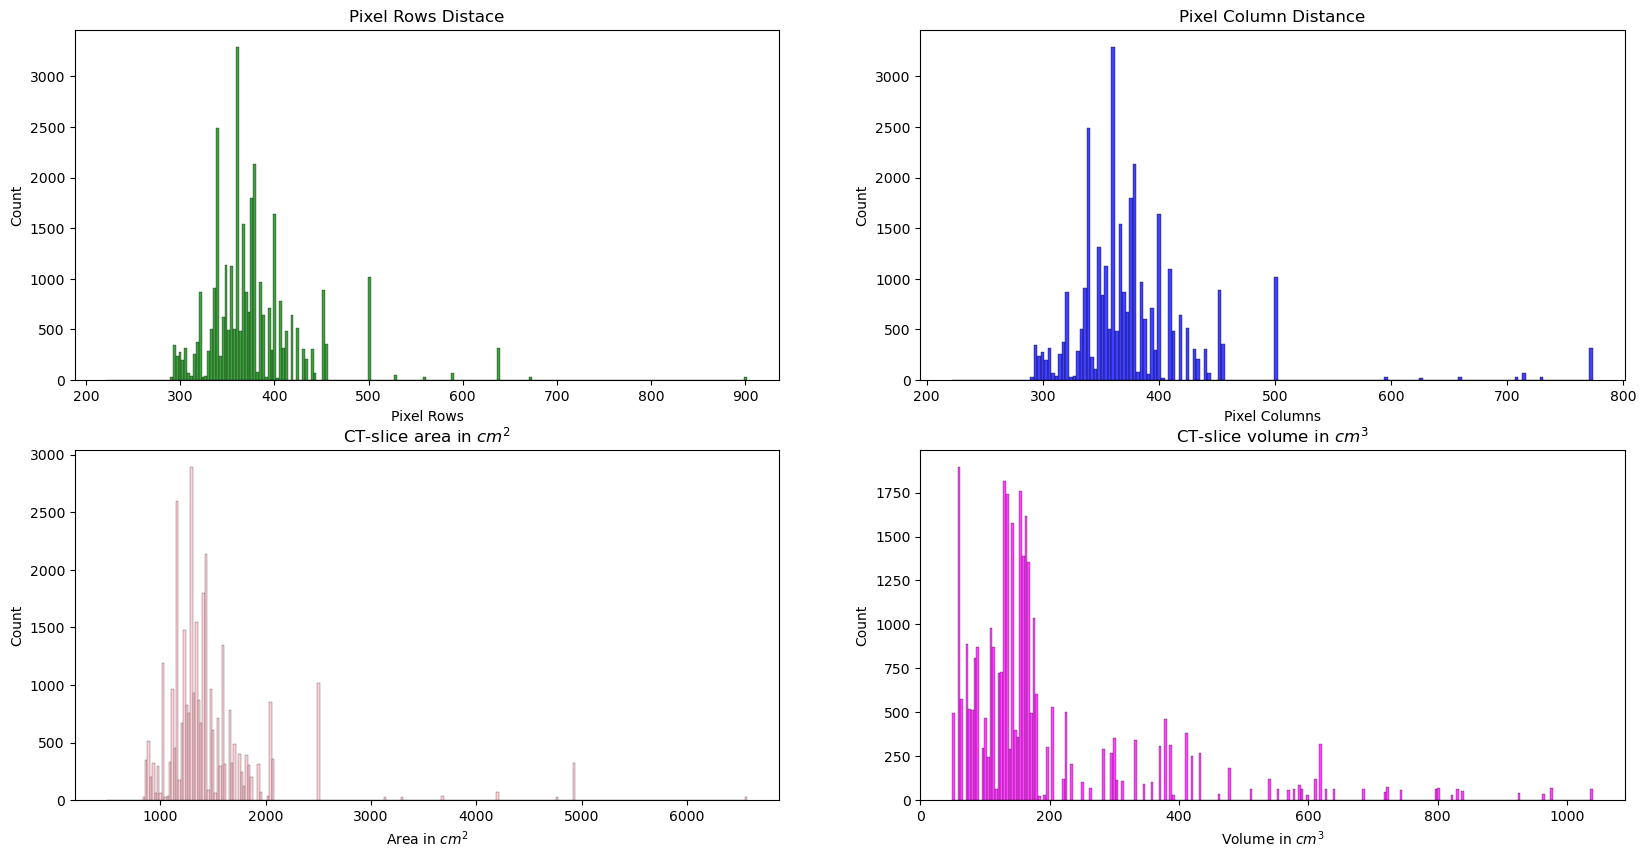

In [19]:
plt.tight_layout()
fig, ax = plt.subplots(2, 2, figsize=(20,10))
sns.histplot(metadata_df.pixel_row_distance, ax = ax[0,0], color='green')
sns.histplot(metadata_df.pixel_col_distance, ax = ax[0,1], color='blue')
sns.histplot(metadata_df.slice_area_cm2, ax=ax[1,0], color='pink')
sns.histplot(metadata_df.slice_vol_cm3, ax=ax[1, 1], color='magenta')
ax[0,0].set_title("Pixel Rows Distace")
ax[0,0].set_xlabel("Pixel Rows")
ax[0,1].set_title("Pixel Column Distance")
ax[0,1].set_xlabel("Pixel Columns")
ax[1,0].set_title("CT-slice area in $cm^{2}$")
ax[1,0].set_xlabel("Area in $cm^{2}$")
ax[1,1].set_title("CT-slice volume in $cm^{3}$")
ax[1,1].set_xlabel("Volume in $cm^{3}$")
plt.show(ax[0,0])

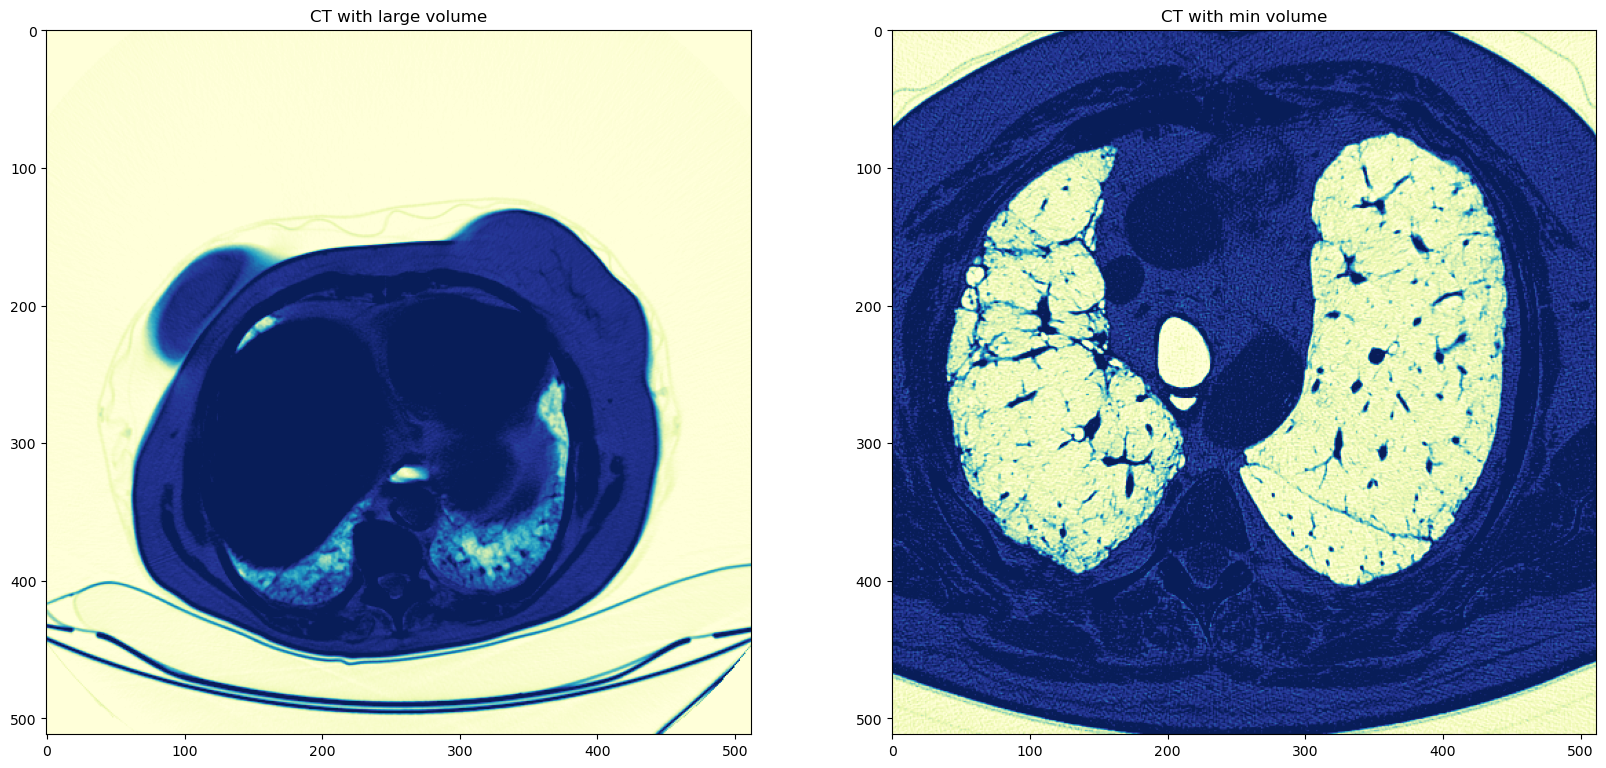

In [20]:
## showing images with maximum volume and minimum volume
highest_vol_patients = list(metadata_df[metadata_df.slice_vol_cm3 == max(metadata_df.slice_vol_cm3)]['PatientID'])
lowest_vol_patients = list(metadata_df[metadata_df.slice_vol_cm3 == min(metadata_df.slice_vol_cm3)]['PatientID'])

#load scans 
max_vol_scans = load_slices(f"{TRAIN_IMG_PATH}/{highest_vol_patients[0]}")
min_vol_scans = load_slices(f"{TRAIN_IMG_PATH}/{lowest_vol_patients[0]}")

#convert to HU
max_vol_hu_imgs = get_pixels_hu(max_vol_scans)
min_vol_hu_imgs = get_pixels_hu(min_vol_scans)

#Apply Windowing

# we can try with different window width and levels
max_vol_window_img = apply_window(max_vol_hu_imgs[20], -600, 1200)
min_vol_window_img = apply_window(min_vol_hu_imgs[18], -600, 1200)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(max_vol_window_img, cmap='YlGnBu')
ax[0].set_title("CT with large volume")
ax[1].imshow(min_vol_window_img, cmap='YlGnBu')
ax[1].set_title("CT with min volume")
plt.show(ax[0], ax[1])

## Resampling



In [21]:
metadata_df.SliceThickness.unique()

#so when slice thickness is different then the voxel size of two images is also very much different

array([1.25    , 2.      , 1.      , 7.      , 0.8     , 0.5     ,
       0.625   , 2.5     , 3.      , 0.9     , 5.      , 0.835938,
       0.75    , 1.5     , 8.      , 6.5     ])

In [22]:
# Lets see thickness for slices before thinking about resampling.
patient1 = train.Patient.unique()[0]
patient2 = train.Patient.unique()[5]
scans1 = load_slices(f"{TRAIN_IMG_PATH}/{patient1}")
scans2 = load_slices(f"{TRAIN_IMG_PATH}/{patient2}")
print(f"{scans1[0].SliceThickness}, {scans1[0].PixelSpacing}")
print(f"{scans2[0].SliceThickness}, {scans2[0].PixelSpacing}")

1.250000, [0.652344, 0.652344]
1.250000, [0.798828, 0.798828]


In [23]:
patient1_hu_scans = get_pixels_hu(scans1)
patient2_hu_scans = get_pixels_hu(scans2)

In [24]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    return image, new_spacing


In [25]:
image1, rounded_new_spacing1 = resample(patient1_hu_scans, scans1, [1,1,1])
image2, rounded_new_spacing2 = resample(patient2_hu_scans, scans2, [1,1,1])
print(f"Original shape : {patient2_hu_scans.shape}")
print(f"Shape after resampling : {image2.shape}")

Original shape : (31, 843, 888)
Shape after resampling : (39, 673, 709)


## 3D Plotting

In [26]:
def plot_3d(image,threshold=800):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the   
    # camera
    p = image.transpose(2,1,0)
    
    verts, faces, _, _ = measure.marching_cubes_lewiner(p, threshold)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    # Fancy indexing: `verts[faces]` to generate a collection of    
    # triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.35, 0.65, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    plt.show()

<ipython-input-26-494062cc5696>:8: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  verts, faces, _, _ = measure.marching_cubes_lewiner(p, threshold)


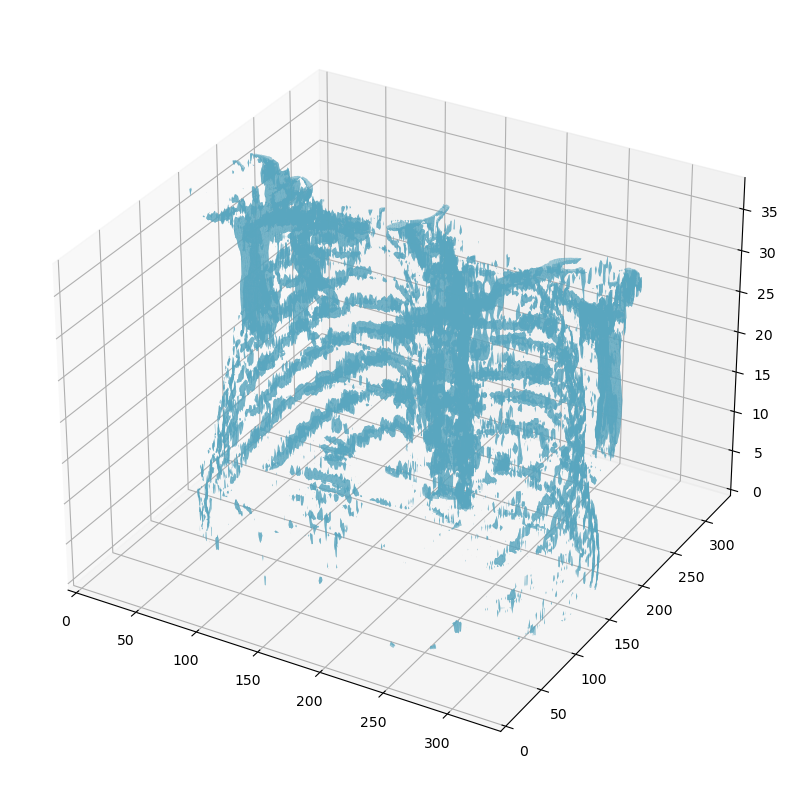

In [27]:
plot_3d(image1)

<ipython-input-26-494062cc5696>:8: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  verts, faces, _, _ = measure.marching_cubes_lewiner(p, threshold)


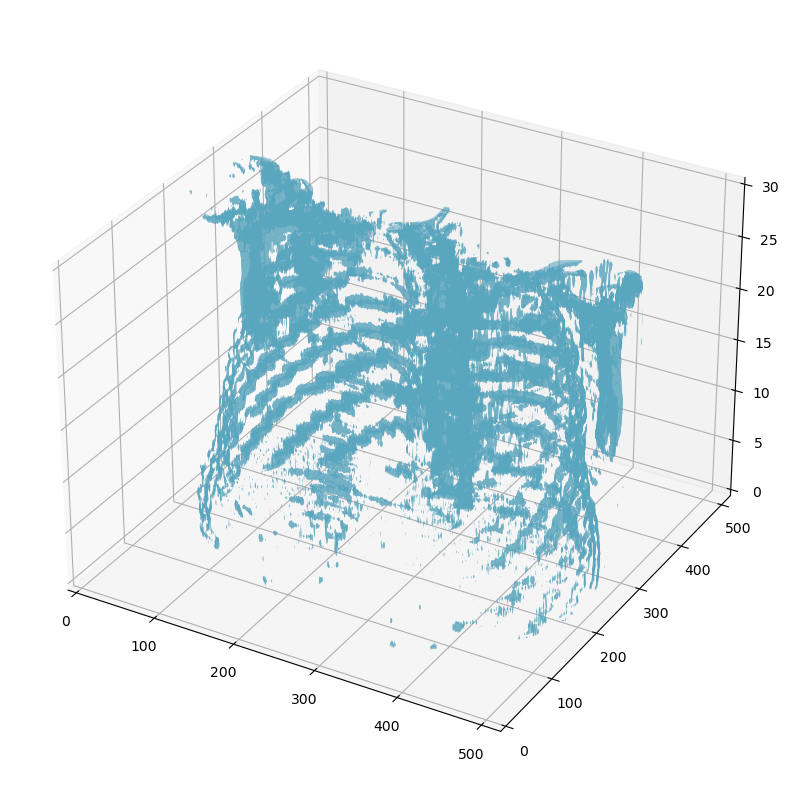

In [28]:
plot_3d(patient1_hu_scans)


## Segmentation

steps
1. Normalization of image
2. Clustering for separating lung with everything else
3. Threshold image
4. morphology- erosion followed by dialation
5. label different regions wih different colors
6. create lung mask
7. apply mask on original image and get final masked image

In [45]:
# Standardize the pixel values
def make_lungmask(img, display=False):
    row_size = img.shape[0]
    col_size = img.shape[1]
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    
    middle = img[int(col_size/5):int(col_size/5*4), int(row_size/5):int(row_size/5*4)]
    mean = np.mean(middle)
    max = np.max(img)
    min = np.min(img)
    
    # to improve threshold finding, i'm moving the underflow and overflow on the pixel spectrum
    
    img[img==max] = mean
    img[img==min] = mean
    
    # using kmeans to seperate foreground ( soft tissue / bone) and background (lung/air)
    
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    
    # Threshold the image and the o/p will be a binary image, morphology works either on binary or gray scale images
    
    thresh_img = np.where(img<threshold, 1.0, 0.0)
    
    eroded = morphology.erosion(thresh_img, np.ones([3,3]))
    dilation = morphology.dilation(eroded, np.ones([8,8]))
    
    labels = measure.label(dilation) # different labels are displayed in different colors
    
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
            
    mask = np.ndarray([row_size, col_size], dtype=np.int8)
    mask[:]=0
    
    # after just the lungs are left, we do another large dilation in prder to fill in and out lung mask
    
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) #last dilation
    
    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img

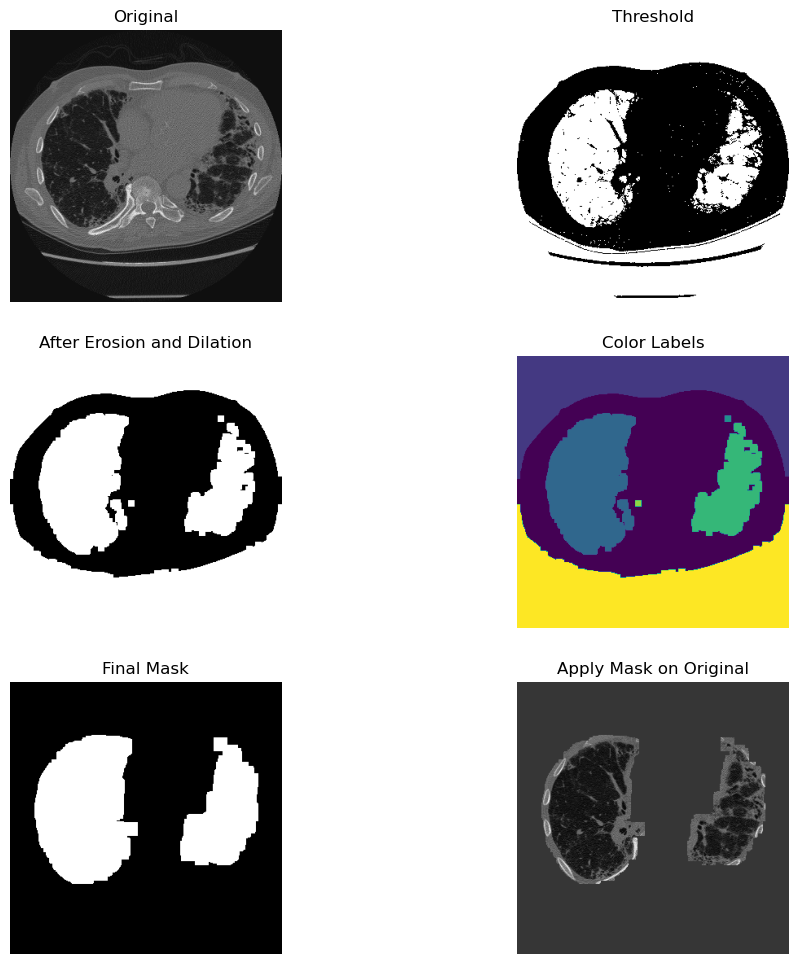

array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])

In [51]:
make_lungmask(image1[14], True)

In [52]:
def get_rows_cols(size):
    cols = 6
    rows = size // cols
    if (int(size%cols) != 0):
        rows = rows+1
    return rows,cols

In [53]:
def plot_stack(stack, start_with=10, show_every=3):
    size = (len(stack) - (start_with - 1))//show_every
    rows, cols = get_rows_cols(size)
    plt.tight_layout()
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(size-1):
        ind = start_with + i*show_every
        ax[int(i/cols),int(i % cols)].set_title('slice %d' % ind)
        ax[int(i/cols),int(i % cols)].imshow(stack[ind],cmap='gray')
        ax[int(i/cols),int(i % cols)].axis('off')
    plt.show()

<Figure size 640x480 with 0 Axes>

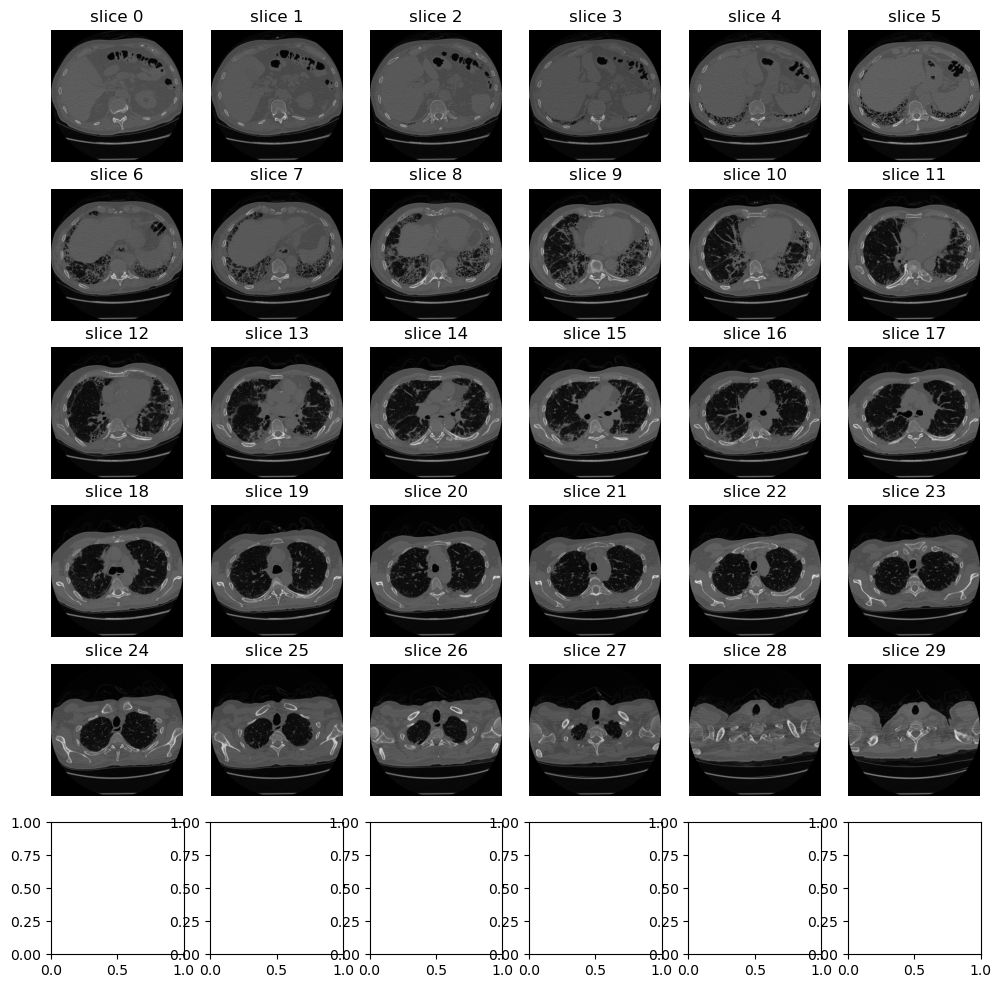

In [54]:
plot_stack(patient1_hu_scans, start_with=0, show_every=1)

<Figure size 640x480 with 0 Axes>

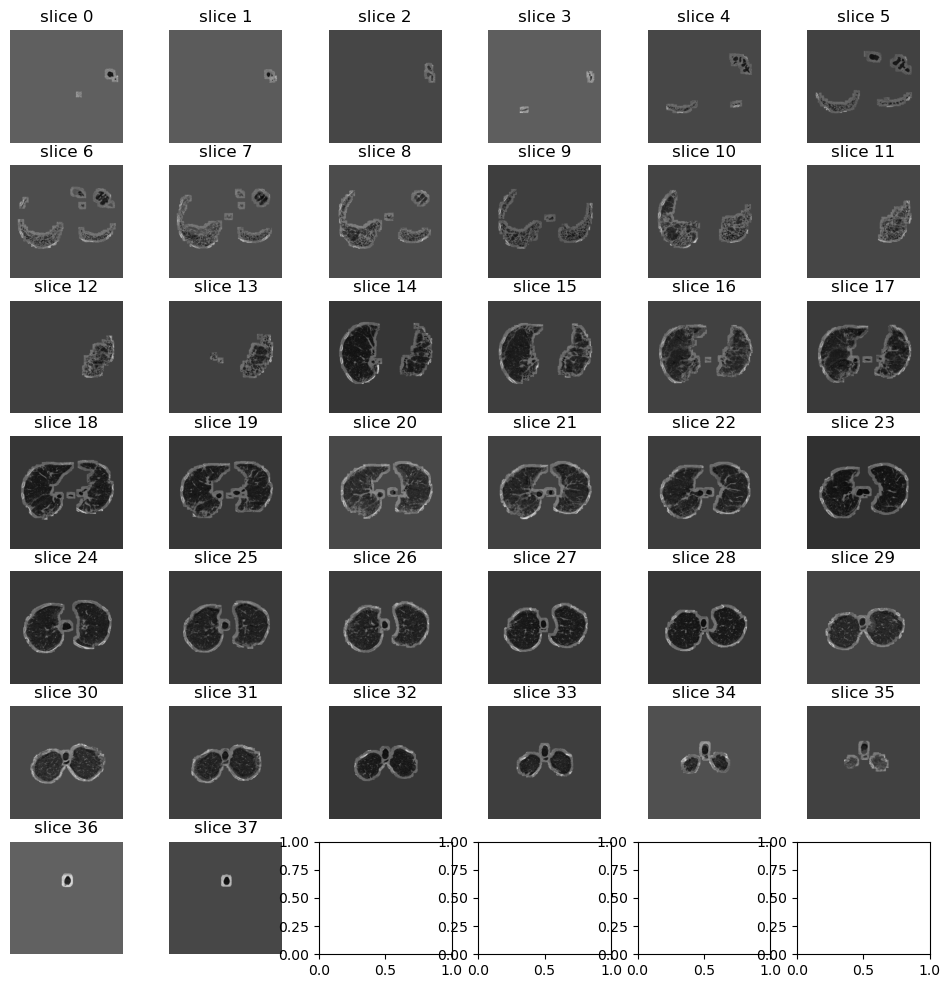

In [55]:
masked_lung = []

for img in image1:
    masked_lung.append(make_lungmask(img))
    
plot_stack(masked_lung, start_with=0, show_every=1)

### To Save Segmented image to png/npz format



path = "./segmented-images"
if not shutil.os.path.isdir(path):
    shutil.os.mkdir(path)

patients = train.Patient.unique()[0:10]
for patient in patients:
    #if not shutil.os.path.isdir(path + "/" + patient):
    #    shutil.os.mkdir(path + "/" + patient)
    scans = load_slices(f'{TRAIN_IMG_PATH}/{patient}')
    hu_imgs = get_pixels_hu(scans)
    rescaled_images, spacing = resample(hu_imgs, scans,[1,1,1])

    masked_lung = []
    for img_number in range(len(rescaled_images)):
        window_img = apply_window(rescaled_images[img_number], -600, 1200)
        masked_img = make_lungmask(window_img)
        masked_lung.append(masked_img)
        #cv2.imwrite(f'{path}/{patient}/{img_number + 1}.png', masked_img)
    # Comment the below line if images required to store in .png format.
    np.savez(f'{path}/{patient}',masked_lung)
